In [96]:
import numpy as np
import matplotlib.pyplot as plt


def leaky_if_3(input_currents=None, duration=0.2, dt=0.0001, increase_threshold=0.012, tau_adapt=0.3):
    """
    Leaky Integrate-and-Fire model with refractory period, background noise,
    and adaptive spike threshold.

    Parameters:
        input_currents (dict): Dictionary with keys:
            - "psc" (ndarray): Vector of time points (in seconds) of excitatory post-synaptic currents.
            - "U_0" (float): Baseline input potential perturbation (default 0.3 V).
            - "ipsc" (ndarray): Vector of time points (in seconds) of inhibitory post-synaptic currents.
        duration (float): Duration of simulation in seconds.
        dt (float): Time step in seconds.
        increase_threshold (float): Voltage increase in the threshold after a spike (default 0.012 V).
        tau_adapt (float): Adaptive decay time constant for the threshold (default 0.3 s).

    Returns:
        time (ndarray): Time points of the simulation.
        U_plot (ndarray): Membrane potential of the neuron over time.
    """
    # Fixed parameters for membrane dynamics
    tau = 0.020  # Membrane time constant in seconds
    R = 3e7  # Membrane resistance in ohms
    U_rest = -0.07  # Resting potential in volts
    theta = -0.030  # Default spike threshold in volts
    spike_volt = 0.1  # Voltage at spike in volts
    arp = 0.006  # Absolute refractory period in seconds (6 ms)
    background_I = 3e-9  # Background noise current in amperes

    # Set default inputs if not provided
    if input_currents is None:
        U_0 = 0.3  # Baseline perturbation in membrane potential (volts)
        I_0 = U_0 / R  # Corresponding current (amperes)
        psc = np.array([0.0])  # Excitatory post-synaptic currents
        ipsc = np.array([])  # Inhibitory post-synaptic currents
    else:
        U_0 = input_currents.get("U_0", 0.3)
        I_0 = U_0 / R
        psc = np.array(input_currents.get("psc", [0.0]))  # Ensure NumPy array
        ipsc = np.array(input_currents.get("ipsc", []))  # Ensure NumPy array

    # Time and simulation setup
    n_steps = int(duration / dt)
    time = np.linspace(0, duration, n_steps + 1)
    index_pscs = np.round(psc / dt).astype(int)
    index_ipscs = np.round(ipsc / dt).astype(int)

    # Initialize variables
    U = np.zeros(n_steps + 1)
    U_plot = np.zeros(n_steps + 1)
    U[0] = U_rest
    U_plot[0] = U_rest
    I = np.zeros(n_steps + 1)
    rand_I = background_I * np.random.normal(0, 1, n_steps)  # Background noise
    theta_adapt = np.ones(n_steps + 1) * theta  # Adaptive spike threshold
    t_spike = 0
    n_spikes = 0

    # Simulation loop
    for i in range(n_steps):
        # Excitatory post-synaptic currents
        if i in index_pscs:
            I[i] += I_0

        # Inhibitory post-synaptic currents
        if i in index_ipscs:
            I[i] -= I_0

        # Membrane potential dynamics
        dU = (dt / tau) * (U_rest - U[i] + I[i] * R + rand_I[i] * R)
        U[i + 1] = U[i] + dU
        U_plot[i + 1] = U[i + 1]

        # Spike detection and refractory period
        if U[i + 1] > theta_adapt[i]:  # Spike condition
            if n_spikes > 0 and time[i] < t_spike + arp:  # Check refractory period
                U[i + 1] = U[i]
                U_plot[i + 1] = U[i + 1]
            else:
                U_plot[i + 1] = spike_volt
                U[i + 1] = U_rest
                t_spike = time[i]
                n_spikes += 1
                theta_adapt[i + 1] = theta_adapt[i] + increase_threshold
        else:
            theta_adapt[i + 1] = theta_adapt[i] + (dt / tau_adapt) * (theta - theta_adapt[i])  # Threshold decay

    # Plot results
    plt.figure()
    plt.plot(time, U_plot, color='black')
    plt.axhline(y=theta, color='red', linestyle='--', label='Threshold')
    plt.title(f"Leaky I&F with adaptive threshold and noise\n"
              f"Rest threshold: {theta * 1000:.1f} mV, Refractory period: {arp * 1000:.1f} ms")
    plt.xlabel("Time (s)")
    plt.ylabel(f"Voltage (V), Spikes: {n_spikes}")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot adaptive threshold dynamics
    plt.figure()
    plt.plot(time, theta_adapt, color='red', label='Adaptive Threshold')
    plt.axhline(y=theta, color='blue', linestyle='--', label='Rest Threshold')
    plt.title(f"Adaptive spike threshold dynamics\n"
              f"Increase: {increase_threshold * 1000:.1f} mV, Tau adapt: {tau_adapt:.3f} s")
    plt.xlabel("Time (s)")
    plt.ylabel("Threshold (V)")
    plt.grid()
    plt.legend()
    plt.show()

    return time, U_plot


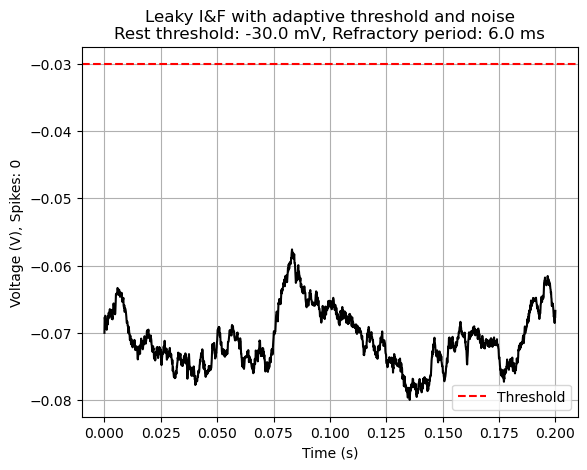

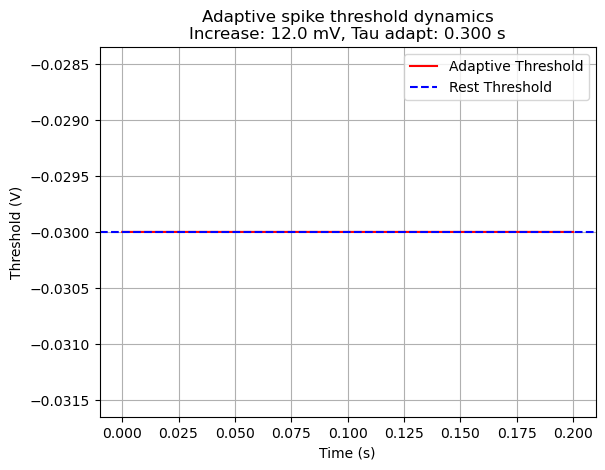

(array([0.000e+00, 1.000e-04, 2.000e-04, ..., 1.998e-01, 1.999e-01,
        2.000e-01]),
 array([-0.07      , -0.06770106, -0.06781717, ..., -0.06752305,
        -0.06772991, -0.0667322 ]))

In [97]:
leaky_if_3()

In [98]:
dt = 1e-4
psc = np.concatenate([np.arange(0.05, 0.055, dt), np.arange(0.1, 0.15, dt)])
ipsc = np.array([])
input_potentials = {
    "U_0": 0.3,
    "psc": psc,
    "ipsc": ipsc,
}

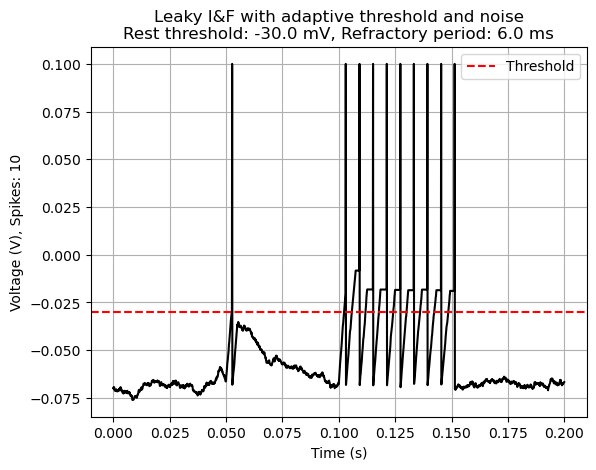

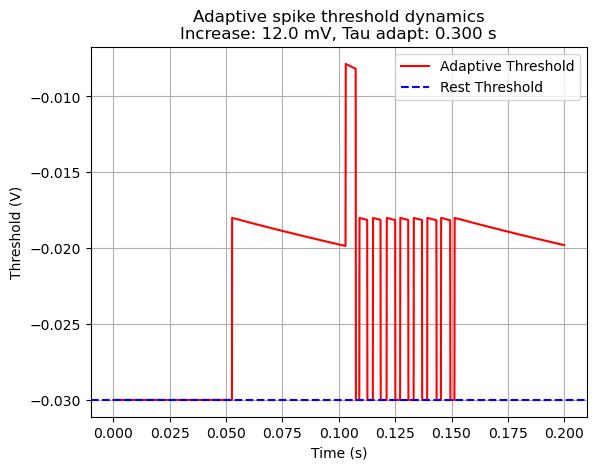

(array([0.000e+00, 1.000e-04, 2.000e-04, ..., 1.998e-01, 1.999e-01,
        2.000e-01]),
 array([-0.07      , -0.07017971, -0.06934784, ..., -0.06697549,
        -0.06690537, -0.06675797]))

In [99]:
leaky_if_3(input_potentials)

In [100]:
def leaky_if_3(input_currents=None, duration=0.2, dt=0.0001, increase_threshold=0.012, tau_adapt=0.3):
    """
    Modified version of Leaky Integrate-and-Fire model to save spike activity as binary output (1 for spike, 0 for no spike).
    """
    # Same initialization as before
    tau = 0.020  # Membrane time constant
    R = 3e7  # Membrane resistance
    U_rest = -0.07  # Resting potential
    theta = -0.030  # Default spike threshold
    spike_volt = 0.1  # Voltage at spike
    arp = 0.006  # Absolute refractory period
    background_I = 3e-9  # Background noise

    if input_currents is None:
        U_0 = 0.3
        I_0 = U_0 / R
        psc = np.array([0.0])
        ipsc = np.array([])
    else:
        U_0 = input_currents.get("U_0", 0.3)
        I_0 = U_0 / R
        psc = np.array(input_currents.get("psc", [0.0]))
        ipsc = np.array(input_currents.get("ipsc", []))

    n_steps = int(duration / dt)
    time = np.linspace(0, duration, n_steps + 1)
    index_pscs = np.round(psc / dt).astype(int)
    index_ipscs = np.round(ipsc / dt).astype(int)

    # Initialize variables
    U = np.zeros(n_steps + 1)
    U[0] = U_rest
    I = np.zeros(n_steps + 1)
    rand_I = background_I * np.random.normal(0, 1, n_steps)
    theta_adapt = np.ones(n_steps + 1) * theta
    t_spike = 0
    spike_train = np.zeros(n_steps + 1)  # Store spikes as 1s and 0s
    n_spikes = 0

    # Simulation loop
    for i in range(n_steps):
        # Excitatory and inhibitory currents
        if i in index_pscs:
            I[i] += I_0
        if i in index_ipscs:
            I[i] -= I_0

        # Membrane potential dynamics
        dU = (dt / tau) * (U_rest - U[i] + I[i] * R + rand_I[i] * R)
        U[i + 1] = U[i] + dU

        # Spike handling
        if U[i + 1] > theta_adapt[i]:
            if n_spikes > 0 and time[i] < t_spike + arp:  # Within refractory
                U[i + 1] = U[i]
            else:
                spike_train[i + 1] = 1  # Record spike
                U[i + 1] = U_rest
                t_spike = time[i]
                n_spikes += 1
                theta_adapt[i + 1] = theta_adapt[i] + increase_threshold
        else:
            theta_adapt[i + 1] = theta_adapt[i] + (dt / tau_adapt) * (theta - theta_adapt[i])

    return time, U, spike_train


In [101]:
# Data preparation
dt = 1e-4  # Define time step
duration = 0.2  # Define simulation duration
psc = np.array([])  # Example input for excitatory currents
ipsc = np.array([])  # Example input for inhibitory currents
input_currents = {
    "U_0": 0.3,
    "psc": psc,
    "ipsc": ipsc,
}

# Run the leaky model to simulate first neuron
time, U_plot, spike_train = leaky_if_3(input_currents=input_currents, duration=duration, dt=dt)

# Store spike_train, which is the spike activity for the first artificial neuron
print("Spike Train (Binary):", spike_train)


Spike Train (Binary): [0. 0. 0. ... 0. 0. 0.]


In [102]:
np.sum(spike_train)

0.0

In [103]:
def simulate_6_neurons(weights, input_currents_list, duration, dt):
    """
    Simulate 6 interconnected neurons using weighted connections.
    Args:
        weights (ndarray): 6x6 matrix of synaptic weights for connections.
        input_currents_list (list): List of input currents (one per neuron).
    """
    n_neurons = 6
    all_spikes = np.zeros((n_neurons, int(duration / dt) + 1))  # Store spikes for all neurons

    # Simulate each neuron
    for i in range(n_neurons):
        time, _, spikes = leaky_if_3(input_currents=input_currents_list[i], duration=duration, dt=dt)
        all_spikes[i] = spikes

    # Add interaction between neurons
    for t in range(1, all_spikes.shape[1]):  # Iterate over time steps
        for i in range(n_neurons):  # Iterate over each neuron
            # Add synaptic input from other neurons
            recurrent_input = np.sum(weights[i, :] * all_spikes[:, t - 1])
            input_currents_list[i]['psc'] += recurrent_input

    return all_spikes


In [104]:
import numpy as np

# Example dataset (from your earlier data):
dataset = np.loadtxt("DataSetCoursework_AMA.txt")

# Parameters
dt = 1e-4  # Define time step (can adjust based on your dataset's time resolution)
duration = dataset.shape[0] * dt  # Calculate total duration based on dataset size
time = np.arange(0, duration, dt)  # Time array for the entire simulation

# Generate 'psc' (excitatory inputs) from the first column
first_column = dataset[:, 0]  # Extract the first column (first neuron)
psc_indices = np.where(first_column == 1)[0] # Find indices where spikes occur
print(f'{len(psc_indices)}')
print(len(first_column))
psc = psc_indices * dt  # Convert spike indices to real times

# Optionally, generate 'ipsc' (inhibitory inputs)
# For simplicity, let's make inhibitory inputs occur randomly
ipsc = np.random.choice(time, size=len(psc) // 2, replace=False)  # Random times for inhibitory inputs

# Output results
print(f"Excitatory inputs (psc): {psc}")
print(f"Inhibitory inputs (ipsc): {ipsc}")


17
4836
Excitatory inputs (psc): [0.0155 0.0232 0.0519 0.1321 0.1419 0.1426 0.1722 0.1838 0.2165 0.3331
 0.3537 0.3714 0.3743 0.4169 0.4245 0.4254 0.4313]
Inhibitory inputs (ipsc): [0.0707 0.2426 0.0361 0.1636 0.1526 0.3099 0.2828 0.2109]


In [105]:
print(psc)
input_currents = {
    "U_0": 0.3,  # Baseline potential (can be adjusted)
    "psc": np.arange(min(psc), max(psc), dt),
    "ipsc": ipsc
}
time, U_plot, spike_train = leaky_if_3(input_currents=input_currents, duration=duration, dt=dt)
spike_train_trimmed = spike_train[1:]
# Output spike train
print("Simulated Spike Train (Binary):", spike_train)

[0.0155 0.0232 0.0519 0.1321 0.1419 0.1426 0.1722 0.1838 0.2165 0.3331
 0.3537 0.3714 0.3743 0.4169 0.4245 0.4254 0.4313]
Simulated Spike Train (Binary): [0. 0. 0. ... 0. 0. 0.]


In [106]:
np.sum(spike_train), len(spike_train_trimmed), len(first_column)

(69.0, 4836, 4836)

In [107]:
psc.ndim

1

In [108]:
def leaky_if_3(input_currents, duration, dt):
    """
    Leaky Integrate-and-Fire model:
    Updates to inject spikes at times provided in psc as a 1D array.

    Args:
        input_currents (dict): Dictionary with `U_0`, `psc`, and `ipsc`.
            - `psc`: 1D array specifying times of excitatory spikes.
            - `ipsc`: 1D array specifying times of inhibitory spikes (optional).
        duration (float): Total simulation time (seconds).
        dt (float): Simulation time step (seconds).

    Returns:
        time (np.ndarray): Time array.
        U_plot (np.ndarray): Membrane potential across all timesteps.
        spike_train (np.ndarray): Binary spike train (1 for spikes, 0 otherwise).
    """
    # Extract PSC and IPSC times
    psc = input_currents["psc"]  # Excitatory spike times
    ipsc = input_currents.get("ipsc", [])  # Inhibitory spike times (can be empty)

    U_0 = input_currents["U_0"]  # Baseline potential
    V_th = 1.0  # Threshold potential, example value
    R = 1.0  # Membrane resistance
    tau = 0.02  # Membrane time constant (20 ms)

    # Convert spike times to indices
    n_steps = int(duration / dt)
    time = np.arange(0, duration, dt)  # Discretized simulation time
    U = np.zeros_like(time)  # Initialize membrane potential
    U[0] = U_0  # Set initial potential
    spike_train = np.zeros_like(time)  # Binary spike train

    # Map `psc` and `ipsc` times to indices
    psc_indices = np.round(psc / dt).astype(int)  # Closest indices for psc
    ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []

    # Inject current when spikes occur
    psc_amplitude = 0.5  # Amplitude of excitatory spike (example value)
    ipsc_amplitude = -0.5  # Amplitude of inhibitory spike (example value)

    for t in range(1, n_steps):
        # Decay membrane potential
        U[t] = U[t - 1] + (-U[t - 1] + R * 0) * (dt / tau)

        # Add PSC if a spike occurs at this time step
        if t in psc_indices:
            U[t] += psc_amplitude

        # Add IPSC if inhibitory spike occurs at this time step
        if t in ipsc_indices:
            U[t] += ipsc_amplitude

        # Check for spike
        if U[t] >= V_th:
            U[t] = 0  # Reset potential
            spike_train[t] = 1  # Record spike in spike train

    return time, U, spike_train


In [130]:
# Optional inhibitory spike times (can be left empty or defined as needed)
ipsc = np.array([])

# Input currents
input_currents = {
    "U_0": 0.3,  # Initial potential
    "psc": psc,
    "ipsc": ipsc
}

# Simulation parameters
dt = 1e-4  # Time step
duration = 0.5  # Duration of simulation

# Run the simulation
time, U_plot, spike_train = leaky_if_3(input_currents, duration, dt)

# Output results
print("Spike Train:", spike_train)
print("Total Spikes:", np.sum(spike_train))


Spike Train: [0. 0. 0. ... 0. 0. 0.]
Total Spikes: 3.0


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_7222/1136779825.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


In [110]:
len(spike_train)

5000

In [125]:
import numpy as np
import matplotlib.pyplot as plt


# Define the function
def plot_raster(dataset, time, title="Raster Plot of Neural Spikes"):
    """
    Plot a raster plot to show spikes across multiple neurons as a function of time.

    Args:
        dataset (np.ndarray): The spike data for neurons (shape: [time_steps, num_neurons]),
                              where each column is a neuron’s spike train (1=spike, 0=rest).
        time (np.ndarray): The time array corresponding to the rows of the dataset.
        title (str): Title for the plot (default: "Raster Plot of Neural Spikes").
    """
    # Ensure the input dataset is 2D
    dataset = np.atleast_2d(dataset)  # This fixes 1D spike_train issues
    num_neurons = dataset.shape[1]  # Number of neurons (columns in dataset)

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Add spikes for each neuron to the raster plot
    for neuron_idx in range(num_neurons):
        spike_times = time[dataset[:, neuron_idx] == 1]  # Find spike times for each neuron
        plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5, color="b", alpha=0.7)

    # Decorations for visualization
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Neurons")
    plt.yticks(
        ticks=np.arange(1, num_neurons + 1),
        labels=[f"Neuron {i + 1}" for i in range(num_neurons)]
    )
    plt.grid(axis="y", alpha=0.25, linestyle="--")
    plt.tight_layout()

    # Show the raster plot
    plt.show()



In [126]:
dt = 0.001  # Example timestep, 1 ms
duration = 1.0  # Example duration, 1 second
time = np.arange(0, duration, dt)

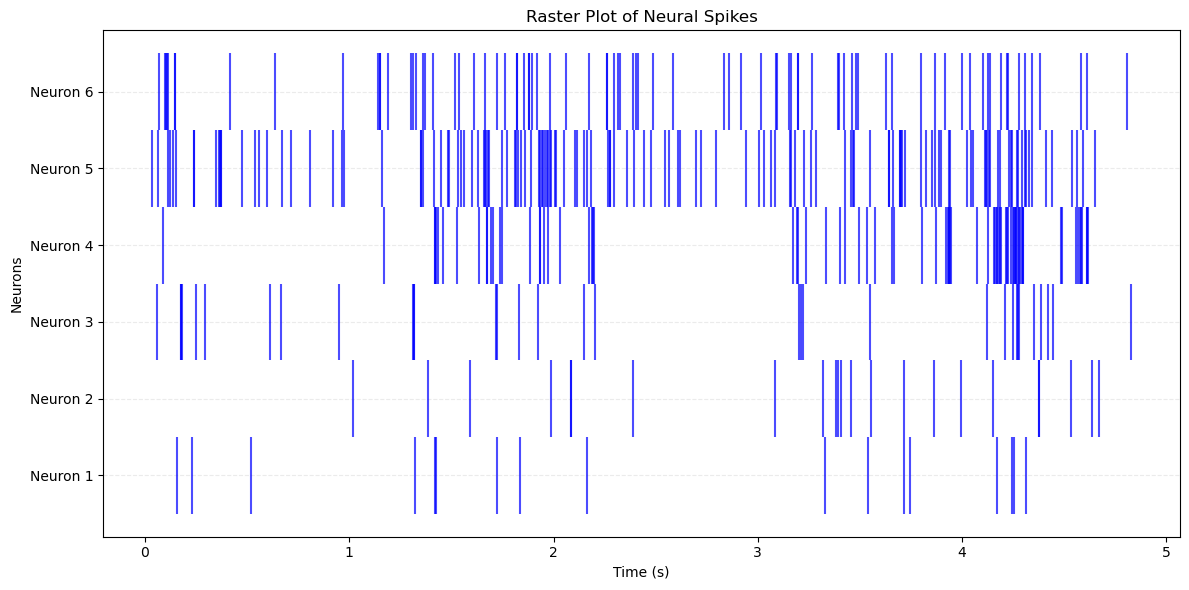

In [127]:
dataset = np.loadtxt("DataSetCoursework_AMA.txt")
dataset = dataset[:, :-2]
dt = 0.001
time = np.arange(0, len(dataset)* dt, dt)
plot_raster(dataset, time)

In [128]:
np.count_nonzero(dataset[:, 0])

17

In [139]:
dt = 0.001
time = np.arange(0, len(spike_train)* dt, dt)
#spike_train = np.atleast_2d(spike_train)
plot_raster(spike_train.flatten(), time)

KeyboardInterrupt: 

In [136]:
condition = (spike_train > 0)
condition.shape

(1, 5000)

In [138]:
U_plot.shape, time.shape, spike_train.shape, condition.shape

((5000,), (5000,), (1, 5000), (1, 5000))

In [140]:
# Optional inhibitory spike times (can be left empty or defined as needed)
ipsc = np.array([])

# Input currents
input_currents = {
    "U_0": 0.3,  # Initial potential
    "psc": psc,
    "ipsc": ipsc
}

# Simulation parameters
dt = 1e-4  # Time step
duration = 0.5  # Duration of simulation

# Run the simulation
time, U_plot, spike_train = leaky_if_3(input_currents, duration, dt)

# Fix shape of spike_train if necessary
spike_train = spike_train.flatten()  # Ensure spike_train is 1D

# Output results
print("Spike Train Shape:", spike_train.shape)
print("Spike Train:", spike_train)
print("Total Spikes:", np.sum(spike_train))


Spike Train Shape: (5000,)
Spike Train: [0. 0. 0. ... 0. 0. 0.]
Total Spikes: 3.0


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_7222/1136779825.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  ipsc_indices = np.round(ipsc / dt).astype(int) if ipsc else []


In [141]:
print("U_plot.shape:", U_plot.shape)
print("time.shape:", time.shape)
print("spike_train.shape:", spike_train.shape)


U_plot.shape: (5000,)
time.shape: (5000,)
spike_train.shape: (5000,)


In [142]:
dt = 0.001
time = np.arange(0, len(spike_train)* dt, dt)
#spike_train = np.atleast_2d(spike_train)
plot_raster(spike_train, time)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5000 but corresponding boolean dimension is 1

<Figure size 1200x600 with 0 Axes>

In [147]:
# Dataset loading (assuming `dataset` is loaded as a NumPy array):
spike_data = np.loadtxt('DataSetCoursework_AMA.txt')[:, :6]  # First 6 columns are spike trains

# Step 1: Compute pairwise correlations
correlation_matrix = np.corrcoef(spike_data.T)  # Compute correlation between all neurons

# Step 2: Convert to inhibitory weights
weight_matrix = -correlation_matrix  # Negate to represent inhibition
np.fill_diagonal(weight_matrix, 0)  # No self-inhibition

print("Weight Matrix (W):")
print(weight_matrix)


Weight Matrix (W):
[[ 0.00000000e+00  4.10583965e-03  4.93130398e-03  7.65645253e-03
   1.02174640e-02  7.85721577e-03]
 [ 4.10583965e-03  0.00000000e+00  5.73946965e-03  8.91122859e-03
  -6.09662418e-03  9.14489386e-03]
 [ 4.93130398e-03  5.73946965e-03  0.00000000e+00  1.07027991e-02
   8.51389030e-05 -6.46021167e-03]
 [ 7.65645253e-03  8.91122859e-03  1.07027991e-02  0.00000000e+00
   3.12576141e-03 -6.35227535e-03]
 [ 1.02174640e-02 -6.09662418e-03  8.51389030e-05  3.12576141e-03
   0.00000000e+00 -4.54467556e-03]
 [ 7.85721577e-03  9.14489386e-03 -6.46021167e-03 -6.35227535e-03
  -4.54467556e-03  0.00000000e+00]]


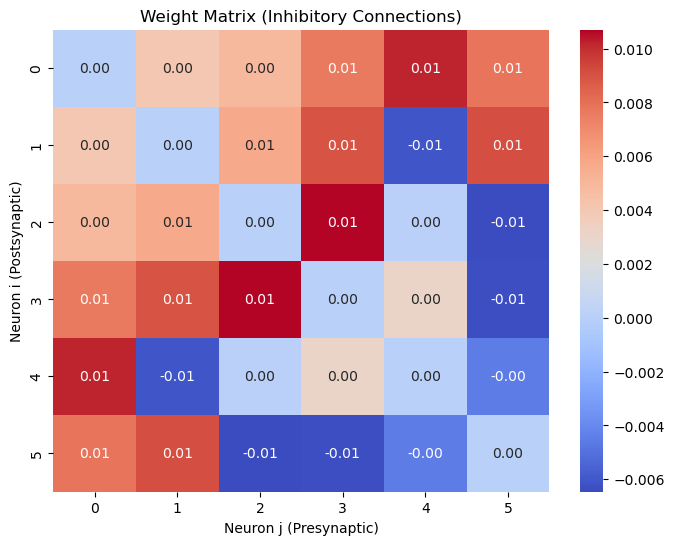

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the weight matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(weight_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Weight Matrix (Inhibitory Connections)")
plt.xlabel("Neuron j (Presynaptic)")
plt.ylabel("Neuron i (Postsynaptic)")
plt.show()
